In [2]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
import tifffile
from skimage.measure import label, regionprops
from skimage.segmentation import chan_vese
from skimage.morphology import binary_closing, disk
from skimage.filters import gaussian
from skimage.exposure import rescale_intensity
from skimage.transform import rescale
from os import listdir
from os.path import join
import tqdm
import pandas as pd
import concurrent.futures
import seaborn as sns

In [14]:
# Constants
pixel_to_micron_xy = 1.2429  # Conversion factor for pixel to microns
dataset_folder = "/mnt/d/collagen_classes/"
num_workers = 4  # Adjust based on CPU cores
slices_used = None
borders_cropped = 20
disk_size = 2
downscale_factor = 0.3
slice_thickness = 1.0
mu = 0.1

In [15]:
def process_image(img):
    """Applies segmentation to a single slice and returns the binary mask."""
    try:
        # Crop borders
        img = img[borders_cropped:-borders_cropped, borders_cropped:-borders_cropped]

        # Normalize and enhance contrast
        img = img / 255.0
        img = rescale_intensity(img)
        img = gaussian(img, sigma=3, preserve_range=True)

        # Apply Chan-Vese segmentation on a downsampled image for speed
        small_img = rescale(img, downscale_factor, anti_aliasing=True)
        cv = chan_vese(small_img, mu=mu, lambda1=0.6, lambda2=1, tol=1e-3, 
                       max_num_iter=70, dt=0.5, init_level_set="checkerboard", extended_output=True)
        segmented_image = np.invert(cv[0]) + 0  # Convert to binary


        # Apply binary closing to smooth segmentation
        segmented_image = binary_closing(segmented_image, disk(disk_size))

        return segmented_image.astype(np.uint8)  # Ensure binary format
    except Exception as e:
        return None


In [16]:
def process_stack(stack_path):
    """Processes a z-stack, reconstructs 3D segmentation, and measures pore volumes."""
    try:
        z_stack = tifffile.imread(stack_path)

        # Use multiprocessing to process slices in parallel
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
            if slices_used:
                results = list(executor.map(process_image, z_stack[-slices_used:, :, :]))
            else:
                results = list(executor.map(process_image, z_stack))

        # Remove None values if any slice processing failed
        results = [r for r in results if r is not None]

        # Convert list of 2D slices into a 3D numpy array
        segmented_volume = np.stack(results, axis=0)

        # Label connected components in 3D
        labeled_volume, num_features = label(segmented_volume, return_num=True)

        # Measure volumes (in voxels)
        regions = regionprops(labeled_volume)
        volumes_voxels = np.array([r.area for r in regions])  # Count voxels per pore

        # Convert voxel count to real-world volume (µm³)
        voxel_volume = (pixel_to_micron_xy ** 2) * slice_thickness  # µm³ per voxel
        volumes_real = volumes_voxels * voxel_volume  # Convert to µm³

        return volumes_real
    except Exception as e:
        print(f"Error processing {stack_path}: {e}")
        return []

In [17]:
category_volumes = {}

for category in listdir(dataset_folder):
    curr_folder_path = join(dataset_folder, category)
    volumes_list = []

    # Parallelize across files
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        file_paths = [join(curr_folder_path, file) for file in listdir(curr_folder_path)]
        results = list(tqdm.tqdm(executor.map(process_stack, file_paths), desc=f"Processing {category}", total=len(file_paths)))

    # Flatten list and store
    category_volumes[category] = np.concatenate([r for r in results if len(r) > 0])

Processing NC: 100%|██████████| 2/2 [00:08<00:00,  4.22s/it]


In [18]:
df = pd.DataFrame([(cat, vol) for cat, vols in category_volumes.items() for vol in vols], 
                  columns=["Category", "Volume"])

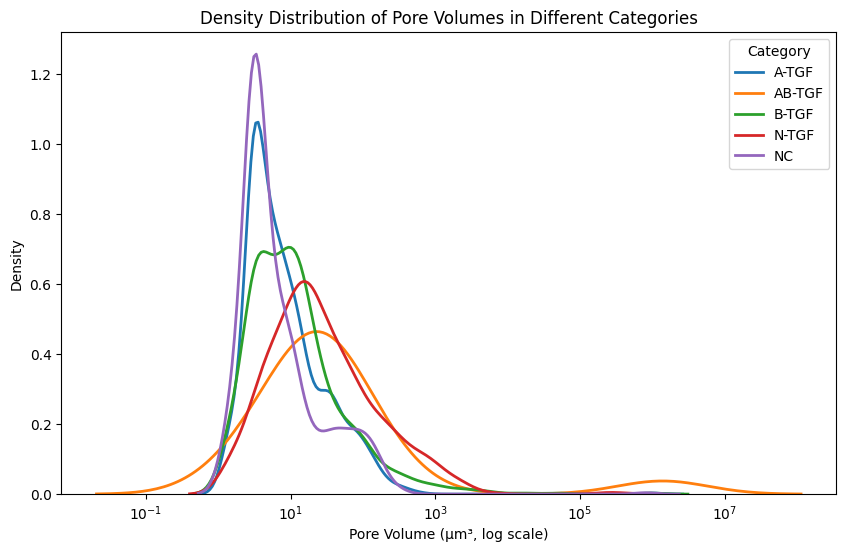

In [20]:
plt.figure(figsize=(10, 6))

# Plot KDE with only contour lines (no fill) for better visibility
for category in df["Category"].unique():
    sns.kdeplot(df[df["Category"] == category]["Volume"], 
                label=category, log_scale=True, linewidth=2)

plt.xlabel("Pore Volume (µm³, log scale)")
plt.ylabel("Density")
plt.title("Density Distribution of Pore Volumes in Different Categories")
plt.legend(title="Category")
plt.show()


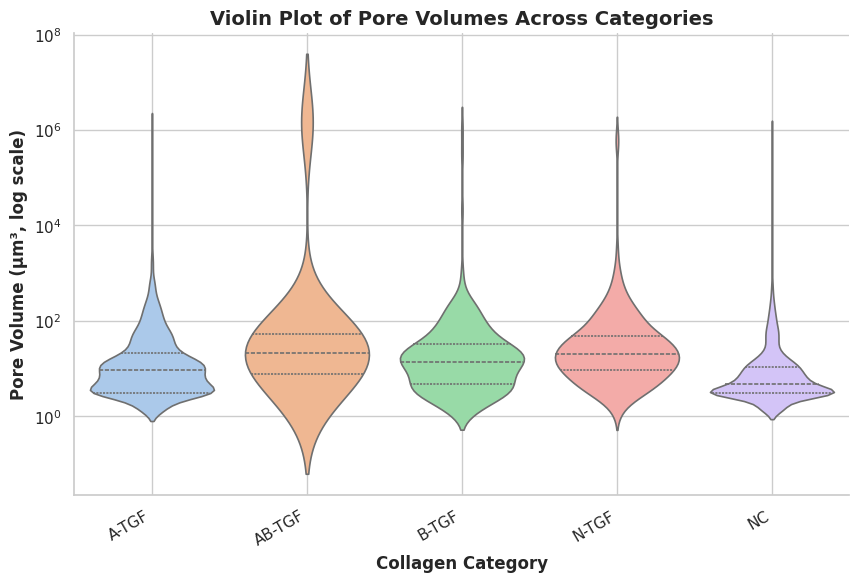

In [19]:
sns.set_theme(style="whitegrid")

# Create violin plot with internal quartiles but no grid
plt.figure(figsize=(10, 6))
ax = sns.violinplot(
    data=df, x="Category", y="Volume", 
    density_norm="width", inner="quartile", log_scale=True, 
    palette="pastel", linewidth=1.2,
    hue="Category"
)

# Improve readability
plt.xlabel("Collagen Category", fontsize=12, fontweight='bold')
plt.ylabel("Pore Volume (µm³, log scale)", fontsize=12, fontweight='bold')
plt.title("Violin Plot of Pore Volumes Across Categories", fontsize=14, fontweight='bold')

# Rotate category labels if needed
plt.xticks(rotation=30, ha='right')

# Remove grid lines
plt.grid(True)  # Removes background grid

# Remove top & right borders for a clean look
sns.despine()

plt.show()